In [117]:
import pandas as pd
import numpy as np
import sklearn
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import catboost as cat

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score,mean_squared_error,accuracy_score,auc,roc_auc_score
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn import svm
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score

from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings('ignore')

In [30]:
train_label_Cls = pd.read_excel("../data/ADMET.xlsx",sheet_name="training")
test_label_Cls = pd.read_excel("../data/ADMET.xlsx",sheet_name="test")

train_data = pd.read_excel("../data/Molecular_Descriptor.xlsx", sheet_name = "training")
test_data = pd.read_excel("../data/Molecular_Descriptor.xlsx", sheet_name = "test")

train_label_Reg = pd.read_excel("../data/ERα_activity.xlsx",sheet_name="training")
test_label_Reg = pd.read_excel("../data/ERα_activity.xlsx",sheet_name="test")

ADMET性质，分别是：
1）小肠上皮细胞渗透性（Caco-2），可度量化合物被人体吸收的能力；
2）细胞色素P450酶（Cytochrome P450, CYP）3A4亚型（CYP3A4），这是人体内的主要代谢酶，可度量化合物的代谢稳定性；
3）化合物心脏安全性评价（human Ether-a-go-go Related Gene, hERG），可度量化合物的心脏毒性；
4）人体口服生物利用度（Human Oral Bioavailability, HOB），可度量药物进入人体后被吸收进入人体血液循环的药量比例；
5）微核试验（Micronucleus，MN），是检测化合物是否具有遗传毒性的一种方法

Caco-2：‘1’代表该化合物的小肠上皮细胞渗透性较好，‘0’代表该化合物的小肠上皮细胞渗透性较差；
CYP3A4：‘1’代表该化合物能够被CYP3A4代谢，‘0’代表该化合物不能被CYP3A4代谢；
hERG：‘1’代表该化合物具有心脏毒性，‘0’代表该化合物不具有心脏毒性；
HOB：‘1’代表该化合物的口服生物利用度较好，‘0’代表该化合物的口服生物利用度较差；
MN：‘1’代表该化合物具有遗传毒性，‘0’代表该化合物不具有遗传毒性。

In [27]:
def rev_one_zero(x):
    if x == 0:
        x=1
        return x
    elif x==1:
        x=0
        return x

In [284]:
train_label_Cls.columns

Index(['SMILES', 'Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN', 'label',
       'realLabel'],
      dtype='object')

In [285]:
precessLabel = train_label_Cls
pd.set_option("display.max_colwidth",None)
train_label_Cls[:100]

,SMILES,Caco-2,CYP3A4,hERG,HOB,MN,label,realLabel
0,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5CCCCC5)cc4,0,1,0,0,1,2,0
1,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN5CCCCC5)cc4,0,1,0,0,1,2,0
2,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN5CCCCC5)cc4,0,1,0,0,0,1,0
3,Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,1,0,0,1,2,0
4,Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,1,0,0,1,2,0
...,...,...,...,...,...,...,...,...
95,Oc1ccc2C(N(CCc2c1)C(=O)C(F)(F)F)c3ccccc3,1,1,1,0,0,3,1
96,CCCc1ccc(cc1)S(=O)(=O)N2CCc3cc(O)ccc3C2c4ccc(OCCN5CCCC5)cc4,0,1,1,0,0,2,0
97,Oc1ccc2C(N(CCc2c1)c3ccccc3)c4ccccc4,1,1,0,0,0,2,0
98,Oc1ccc2C(N(CCc2c1)C(=O)C(F)(F)F)c3cccs3,1,1,1,0,0,3,1


In [32]:
train_label_Cls["hERG"].value_counts()

1    1099
0     875
Name: hERG, dtype: int64

In [33]:
train_label_Cls["MN"].value_counts()

1    1514
0     460
Name: MN, dtype: int64

In [38]:
precessLabel["hERG"].value_counts()

0    1099
1     875
Name: hERG, dtype: int64

In [41]:
precessLabel["MN"].value_counts()

0    1514
1     460
Name: MN, dtype: int64

In [37]:
precessLabel["hERG"] = precessLabel["hERG"].apply(lambda x: rev_one_zero(x))

In [40]:
precessLabel["MN"] = precessLabel["MN"].apply(lambda x: rev_one_zero(x))

为了方便打标签，我们将毒性类别的0，1交换，用1代表无毒，0代表有毒

In [282]:
precessLabel[:100]

,SMILES,Caco-2,CYP3A4,hERG,HOB,MN,label,realLabel
0,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5C...,0,1,0,0,1,2,0
1,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN...,0,1,0,0,1,2,0
2,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...,0,1,0,0,0,1,0
3,Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCC...,0,1,0,0,1,2,0
4,Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCC...,0,1,0,0,1,2,0
...,...,...,...,...,...,...,...,...
95,Oc1ccc2C(N(CCc2c1)C(=O)C(F)(F)F)c3ccccc3,1,1,1,0,0,3,1
96,CCCc1ccc(cc1)S(=O)(=O)N2CCc3cc(O)ccc3C2c4ccc(O...,0,1,1,0,0,2,0
97,Oc1ccc2C(N(CCc2c1)c3ccccc3)c4ccccc4,1,1,0,0,0,2,0
98,Oc1ccc2C(N(CCc2c1)C(=O)C(F)(F)F)c3cccs3,1,1,1,0,0,3,1


打标签，若出现三个好指标（ADMET的和大于等于3）则打为正样本，否则打为负样本
为什么为3？因为题目要求至少三个指标表现好

In [47]:
sum(precessLabel.loc[1,['Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN']].values)

2

In [55]:
def calLabel(x):
    labelCol = ['Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN']
    return sum(x[labelCol].values)

In [58]:
precessLabel["label"] = precessLabel.apply(lambda x : calLabel(x), axis=1)

In [60]:
precessLabel["label"].value_counts()

1    709
2    630
3    444
4    177
5     11
0      3
Name: label, dtype: int64

In [67]:
def getRealLabel(x):
    if x>=3:
        x = 1
        return x
    if x<3:
        x = 0
        return x

In [68]:
precessLabel["realLabel"] = precessLabel["label"].apply(lambda x : getRealLabel(x))

In [69]:
precessLabel["realLabel"].value_counts()

0    1342
1     632
Name: realLabel, dtype: int64

此题思路为融合贪心算法和遗传算法，我们首先找出一个对分类好的模型，确定并训练分类表现最好的模型
通过这个模型用PI来选择特征，选择之后我们来利用第一问中的最好的回归模型结合
通过贪心算法，优先优化回归参数，之后固定回归参数，来优化分类参数
优化算法选择可以为贪心，粒子群，蚁群等算法

In [70]:
#分类模型前预处理，仍然是去除全0值
df1=train_data.loc[:, (train_data == 0).all(axis=0)]
zero_features = list(df1.columns)
print(f"全部为0的列有{len(zero_features)}列")
#排除train中全部为0的列
exclude_col = ['SMILES'] + zero_features

全部为0的列有225列


In [72]:
all_cols = [f for f in train_data.columns if f not in exclude_col]
x_train_Cls = train_data[all_cols]
x_test = test_data[all_cols]

In [74]:
#获取重新打好的分类标签:
y_Cls = precessLabel["realLabel"]

第一步，不做太多处理，选出一个最好的分类模型

In [113]:
#划分数据集
train_x, val_x, train_y, val_y = train_test_split(x_train_Cls, y_Cls, test_size=0.2,random_state=1)

In [142]:
def generateClsOut(model,train_x, val_x, train_y, val_y):
    
    model.fit(train_x, train_y)
    val_pred = model.predict(val_x)
    #test_pred = model.predict(x_test)
    acc = accuracy_score(val_y, val_pred)
    recall = recall_score(val_y, val_pred)
    f1 = f1_score(val_y, val_pred)
    precision = precision_score(val_y, val_pred)
    print(f"acc:{acc},recall:{recall},F1:{f1},Precision:{precision}")

In [111]:
#LGB初步预测结果
model = lgb.LGBMClassifier(max_depth=6)
generateClsOut(model,train_x, val_x, train_y, val_y)

acc:0.830379746835443,recall:0.7355371900826446,F1:0.726530612244898,Precision:0.717741935483871


In [86]:
#XGB初步预测结果
model = XGBClassifier()
generateClsOut(model,train_x, val_x, train_y, val_y)

[11:10:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc:0.8405063291139241,recall:0.7355371900826446,F1:0.7385892116182573,Precision:0.7416666666666667


In [87]:
#Cat初步预测结果
model = CatBoostClassifier()
generateClsOut(model,train_x, val_x, train_y, val_y)

Learning rate set to 0.012521
0:	learn: 0.6848229	total: 64.2ms	remaining: 1m 4s
1:	learn: 0.6780459	total: 120ms	remaining: 59.8s
2:	learn: 0.6706851	total: 175ms	remaining: 58s
3:	learn: 0.6623701	total: 235ms	remaining: 58.6s
4:	learn: 0.6551713	total: 288ms	remaining: 57.4s
5:	learn: 0.6474501	total: 340ms	remaining: 56.4s
6:	learn: 0.6407306	total: 392ms	remaining: 55.6s
7:	learn: 0.6337168	total: 443ms	remaining: 55s
8:	learn: 0.6273895	total: 501ms	remaining: 55.2s
9:	learn: 0.6202284	total: 556ms	remaining: 55.1s
10:	learn: 0.6140651	total: 609ms	remaining: 54.8s
11:	learn: 0.6092234	total: 661ms	remaining: 54.4s
12:	learn: 0.6035201	total: 712ms	remaining: 54.1s
13:	learn: 0.5977286	total: 771ms	remaining: 54.3s
14:	learn: 0.5928271	total: 823ms	remaining: 54s
15:	learn: 0.5882771	total: 874ms	remaining: 53.8s
16:	learn: 0.5823254	total: 933ms	remaining: 54s
17:	learn: 0.5773724	total: 994ms	remaining: 54.2s
18:	learn: 0.5727722	total: 1.06s	remaining: 54.9s
19:	learn: 0.56761

163:	learn: 0.3240600	total: 9.16s	remaining: 46.7s
164:	learn: 0.3234912	total: 9.21s	remaining: 46.6s
165:	learn: 0.3230812	total: 9.27s	remaining: 46.6s
166:	learn: 0.3224103	total: 9.32s	remaining: 46.5s
167:	learn: 0.3219336	total: 9.37s	remaining: 46.4s
168:	learn: 0.3212376	total: 9.43s	remaining: 46.4s
169:	learn: 0.3203044	total: 9.48s	remaining: 46.3s
170:	learn: 0.3199308	total: 9.53s	remaining: 46.2s
171:	learn: 0.3192038	total: 9.58s	remaining: 46.1s
172:	learn: 0.3183047	total: 9.63s	remaining: 46.1s
173:	learn: 0.3179154	total: 9.69s	remaining: 46s
174:	learn: 0.3174315	total: 9.74s	remaining: 45.9s
175:	learn: 0.3166858	total: 9.8s	remaining: 45.9s
176:	learn: 0.3160727	total: 9.85s	remaining: 45.8s
177:	learn: 0.3153226	total: 9.9s	remaining: 45.7s
178:	learn: 0.3148009	total: 9.96s	remaining: 45.7s
179:	learn: 0.3141967	total: 10s	remaining: 45.6s
180:	learn: 0.3136165	total: 10.1s	remaining: 45.5s
181:	learn: 0.3130173	total: 10.1s	remaining: 45.5s
182:	learn: 0.3124

323:	learn: 0.2514681	total: 17.7s	remaining: 36.9s
324:	learn: 0.2510753	total: 17.7s	remaining: 36.9s
325:	learn: 0.2509244	total: 17.8s	remaining: 36.8s
326:	learn: 0.2506567	total: 17.8s	remaining: 36.7s
327:	learn: 0.2504233	total: 17.9s	remaining: 36.7s
328:	learn: 0.2501118	total: 18s	remaining: 36.6s
329:	learn: 0.2497814	total: 18s	remaining: 36.6s
330:	learn: 0.2495021	total: 18.1s	remaining: 36.5s
331:	learn: 0.2492200	total: 18.1s	remaining: 36.4s
332:	learn: 0.2489597	total: 18.2s	remaining: 36.4s
333:	learn: 0.2485872	total: 18.2s	remaining: 36.3s
334:	learn: 0.2481345	total: 18.3s	remaining: 36.3s
335:	learn: 0.2478267	total: 18.3s	remaining: 36.2s
336:	learn: 0.2474950	total: 18.4s	remaining: 36.2s
337:	learn: 0.2471106	total: 18.4s	remaining: 36.1s
338:	learn: 0.2465072	total: 18.5s	remaining: 36s
339:	learn: 0.2461767	total: 18.5s	remaining: 36s
340:	learn: 0.2459342	total: 18.6s	remaining: 35.9s
341:	learn: 0.2456541	total: 18.6s	remaining: 35.9s
342:	learn: 0.245258

483:	learn: 0.2059180	total: 26.2s	remaining: 27.9s
484:	learn: 0.2057418	total: 26.3s	remaining: 27.9s
485:	learn: 0.2054804	total: 26.3s	remaining: 27.8s
486:	learn: 0.2051322	total: 26.4s	remaining: 27.8s
487:	learn: 0.2048950	total: 26.4s	remaining: 27.7s
488:	learn: 0.2047859	total: 26.5s	remaining: 27.7s
489:	learn: 0.2046778	total: 26.5s	remaining: 27.6s
490:	learn: 0.2045782	total: 26.6s	remaining: 27.5s
491:	learn: 0.2042231	total: 26.6s	remaining: 27.5s
492:	learn: 0.2039757	total: 26.7s	remaining: 27.4s
493:	learn: 0.2039192	total: 26.7s	remaining: 27.4s
494:	learn: 0.2038799	total: 26.8s	remaining: 27.3s
495:	learn: 0.2036092	total: 26.8s	remaining: 27.3s
496:	learn: 0.2034014	total: 26.9s	remaining: 27.2s
497:	learn: 0.2030856	total: 26.9s	remaining: 27.2s
498:	learn: 0.2027702	total: 27s	remaining: 27.1s
499:	learn: 0.2024663	total: 27s	remaining: 27s
500:	learn: 0.2022590	total: 27.1s	remaining: 27s
501:	learn: 0.2021233	total: 27.2s	remaining: 26.9s
502:	learn: 0.201838

644:	learn: 0.1724466	total: 35.1s	remaining: 19.3s
645:	learn: 0.1722994	total: 35.1s	remaining: 19.3s
646:	learn: 0.1720567	total: 35.2s	remaining: 19.2s
647:	learn: 0.1719174	total: 35.2s	remaining: 19.1s
648:	learn: 0.1718683	total: 35.3s	remaining: 19.1s
649:	learn: 0.1716459	total: 35.4s	remaining: 19s
650:	learn: 0.1716171	total: 35.4s	remaining: 19s
651:	learn: 0.1712488	total: 35.5s	remaining: 19s
652:	learn: 0.1710299	total: 35.6s	remaining: 18.9s
653:	learn: 0.1705395	total: 35.6s	remaining: 18.9s
654:	learn: 0.1703197	total: 35.7s	remaining: 18.8s
655:	learn: 0.1701979	total: 35.8s	remaining: 18.8s
656:	learn: 0.1701317	total: 35.9s	remaining: 18.7s
657:	learn: 0.1699240	total: 35.9s	remaining: 18.7s
658:	learn: 0.1697614	total: 36s	remaining: 18.6s
659:	learn: 0.1696831	total: 36.1s	remaining: 18.6s
660:	learn: 0.1693846	total: 36.1s	remaining: 18.5s
661:	learn: 0.1691142	total: 36.2s	remaining: 18.5s
662:	learn: 0.1690304	total: 36.2s	remaining: 18.4s
663:	learn: 0.168852

804:	learn: 0.1426662	total: 44.7s	remaining: 10.8s
805:	learn: 0.1426173	total: 44.7s	remaining: 10.8s
806:	learn: 0.1424439	total: 44.8s	remaining: 10.7s
807:	learn: 0.1421477	total: 44.8s	remaining: 10.7s
808:	learn: 0.1421300	total: 44.9s	remaining: 10.6s
809:	learn: 0.1419706	total: 44.9s	remaining: 10.5s
810:	learn: 0.1416889	total: 45s	remaining: 10.5s
811:	learn: 0.1413595	total: 45s	remaining: 10.4s
812:	learn: 0.1412874	total: 45.1s	remaining: 10.4s
813:	learn: 0.1409439	total: 45.2s	remaining: 10.3s
814:	learn: 0.1407048	total: 45.2s	remaining: 10.3s
815:	learn: 0.1405824	total: 45.3s	remaining: 10.2s
816:	learn: 0.1404156	total: 45.3s	remaining: 10.2s
817:	learn: 0.1403920	total: 45.4s	remaining: 10.1s
818:	learn: 0.1400959	total: 45.4s	remaining: 10s
819:	learn: 0.1400797	total: 45.5s	remaining: 9.99s
820:	learn: 0.1400591	total: 45.5s	remaining: 9.93s
821:	learn: 0.1399512	total: 45.6s	remaining: 9.88s
822:	learn: 0.1396155	total: 45.7s	remaining: 9.82s
823:	learn: 0.1393

964:	learn: 0.1181578	total: 54.3s	remaining: 1.97s
965:	learn: 0.1179641	total: 54.3s	remaining: 1.91s
966:	learn: 0.1179284	total: 54.4s	remaining: 1.86s
967:	learn: 0.1177082	total: 54.4s	remaining: 1.8s
968:	learn: 0.1175289	total: 54.5s	remaining: 1.74s
969:	learn: 0.1173038	total: 54.6s	remaining: 1.69s
970:	learn: 0.1170880	total: 54.6s	remaining: 1.63s
971:	learn: 0.1169467	total: 54.7s	remaining: 1.57s
972:	learn: 0.1168470	total: 54.7s	remaining: 1.52s
973:	learn: 0.1166069	total: 54.8s	remaining: 1.46s
974:	learn: 0.1165844	total: 54.8s	remaining: 1.41s
975:	learn: 0.1163784	total: 54.9s	remaining: 1.35s
976:	learn: 0.1162359	total: 55s	remaining: 1.29s
977:	learn: 0.1162213	total: 55s	remaining: 1.24s
978:	learn: 0.1161050	total: 55.1s	remaining: 1.18s
979:	learn: 0.1159115	total: 55.1s	remaining: 1.13s
980:	learn: 0.1158820	total: 55.2s	remaining: 1.07s
981:	learn: 0.1158601	total: 55.2s	remaining: 1.01s
982:	learn: 0.1156581	total: 55.3s	remaining: 956ms
983:	learn: 0.115

In [88]:
#svm初步预测结果
model = svm.SVC()
generateClsOut(model,train_x, val_x, train_y, val_y)

acc:0.7569620253164557,recall:0.3884297520661157,F1:0.4947368421052632,Precision:0.6811594202898551


回归模型的初步训练

In [93]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

In [90]:
y_pIC50 = train_label_Reg["pIC50"]

In [95]:
train_reg_x, val_reg_x, train_reg_y, val_reg_y = train_test_split(x_train_Cls, y_pIC50, test_size=0.2,random_state=1)

In [147]:
def generateRegOut(model,train_x, val_x, train_y, val_y):
    
    model.fit(train_x, train_y)
    val_pred = model.predict(val_x)
    #test_pred = model.predict(x_test)
    MSE = mean_squared_error(val_y, val_pred)
    RMSE = np.sqrt(mean_squared_error(val_y, val_pred))
    MAE = mean_absolute_error(val_y, val_pred)
    R2 = r2_score(val_y, val_pred)
    print(f"MSE:{MSE},RMSE:{RMSE},MAE:{MAE},R2:{R2}")

In [97]:
#svm初步预测结果
model = svm.SVR()
generateRegOut(model,train_reg_x, val_reg_x, train_reg_y, val_reg_y)

MSE:1.6996914781212442,RMSE:1.3037221629324418,MAE:1.0657528816098167,R2:0.16622737181062108


In [98]:
#LGB初步预测结果
model = lgb.LGBMRegressor()
generateRegOut(model,train_reg_x, val_reg_x, train_reg_y, val_reg_y)

MSE:0.5053079081032108,RMSE:0.710850130550182,MAE:0.48892824524584005,R2:0.7521244837623186


In [99]:
#XGB初步预测结果
model = xgb.XGBRegressor()
generateRegOut(model,train_reg_x, val_reg_x, train_reg_y, val_reg_y)

MSE:0.5849782552555755,RMSE:0.7648387119227004,MAE:0.5300897544262844,R2:0.71304271181191


In [102]:
#Cat初步结果
model = cat.CatBoostRegressor()
generateRegOut(model,train_reg_x, val_reg_x, train_reg_y, val_reg_y)

Learning rate set to 0.042336
0:	learn: 1.3904298	total: 116ms	remaining: 1m 56s
1:	learn: 1.3615517	total: 173ms	remaining: 1m 26s
2:	learn: 1.3338786	total: 228ms	remaining: 1m 15s
3:	learn: 1.3089842	total: 284ms	remaining: 1m 10s
4:	learn: 1.2830429	total: 337ms	remaining: 1m 7s
5:	learn: 1.2563974	total: 392ms	remaining: 1m 4s
6:	learn: 1.2347395	total: 451ms	remaining: 1m 3s
7:	learn: 1.2141214	total: 506ms	remaining: 1m 2s
8:	learn: 1.1919779	total: 561ms	remaining: 1m 1s
9:	learn: 1.1731922	total: 620ms	remaining: 1m 1s
10:	learn: 1.1596271	total: 634ms	remaining: 57s
11:	learn: 1.1423233	total: 690ms	remaining: 56.8s
12:	learn: 1.1251703	total: 743ms	remaining: 56.4s
13:	learn: 1.1105261	total: 796ms	remaining: 56.1s
14:	learn: 1.0945690	total: 854ms	remaining: 56.1s
15:	learn: 1.0786764	total: 912ms	remaining: 56.1s
16:	learn: 1.0627991	total: 968ms	remaining: 56s
17:	learn: 1.0480700	total: 1.03s	remaining: 56.1s
18:	learn: 1.0344535	total: 1.09s	remaining: 56.4s
19:	learn: 

162:	learn: 0.5915114	total: 9.29s	remaining: 47.7s
163:	learn: 0.5910301	total: 9.36s	remaining: 47.7s
164:	learn: 0.5900692	total: 9.41s	remaining: 47.6s
165:	learn: 0.5887713	total: 9.46s	remaining: 47.5s
166:	learn: 0.5876341	total: 9.52s	remaining: 47.5s
167:	learn: 0.5862586	total: 9.58s	remaining: 47.4s
168:	learn: 0.5851964	total: 9.63s	remaining: 47.4s
169:	learn: 0.5845210	total: 9.68s	remaining: 47.3s
170:	learn: 0.5838181	total: 9.74s	remaining: 47.2s
171:	learn: 0.5824468	total: 9.8s	remaining: 47.2s
172:	learn: 0.5816992	total: 9.85s	remaining: 47.1s
173:	learn: 0.5808260	total: 9.9s	remaining: 47s
174:	learn: 0.5795184	total: 9.95s	remaining: 46.9s
175:	learn: 0.5781944	total: 10s	remaining: 46.9s
176:	learn: 0.5772590	total: 10.1s	remaining: 46.8s
177:	learn: 0.5764475	total: 10.1s	remaining: 46.7s
178:	learn: 0.5749927	total: 10.2s	remaining: 46.6s
179:	learn: 0.5741065	total: 10.2s	remaining: 46.6s
180:	learn: 0.5729330	total: 10.3s	remaining: 46.5s
181:	learn: 0.5721

322:	learn: 0.4649150	total: 18.7s	remaining: 39.1s
323:	learn: 0.4641624	total: 18.7s	remaining: 39.1s
324:	learn: 0.4633778	total: 18.8s	remaining: 39s
325:	learn: 0.4624230	total: 18.9s	remaining: 39s
326:	learn: 0.4615811	total: 18.9s	remaining: 39s
327:	learn: 0.4609933	total: 19s	remaining: 38.9s
328:	learn: 0.4604993	total: 19s	remaining: 38.8s
329:	learn: 0.4598065	total: 19.1s	remaining: 38.8s
330:	learn: 0.4592204	total: 19.1s	remaining: 38.7s
331:	learn: 0.4586493	total: 19.2s	remaining: 38.6s
332:	learn: 0.4582602	total: 19.2s	remaining: 38.5s
333:	learn: 0.4578026	total: 19.3s	remaining: 38.5s
334:	learn: 0.4572149	total: 19.3s	remaining: 38.4s
335:	learn: 0.4563605	total: 19.4s	remaining: 38.3s
336:	learn: 0.4555149	total: 19.5s	remaining: 38.3s
337:	learn: 0.4549312	total: 19.5s	remaining: 38.2s
338:	learn: 0.4545299	total: 19.6s	remaining: 38.1s
339:	learn: 0.4539353	total: 19.6s	remaining: 38.1s
340:	learn: 0.4532524	total: 19.7s	remaining: 38s
341:	learn: 0.4524919	to

484:	learn: 0.3817768	total: 27.4s	remaining: 29.1s
485:	learn: 0.3817075	total: 27.5s	remaining: 29.1s
486:	learn: 0.3811088	total: 27.5s	remaining: 29s
487:	learn: 0.3807819	total: 27.6s	remaining: 28.9s
488:	learn: 0.3801530	total: 27.6s	remaining: 28.9s
489:	learn: 0.3797654	total: 27.7s	remaining: 28.8s
490:	learn: 0.3792908	total: 27.8s	remaining: 28.8s
491:	learn: 0.3789532	total: 27.8s	remaining: 28.7s
492:	learn: 0.3782781	total: 27.9s	remaining: 28.7s
493:	learn: 0.3779446	total: 27.9s	remaining: 28.6s
494:	learn: 0.3776151	total: 28s	remaining: 28.5s
495:	learn: 0.3772608	total: 28s	remaining: 28.5s
496:	learn: 0.3768212	total: 28.1s	remaining: 28.4s
497:	learn: 0.3767374	total: 28.1s	remaining: 28.4s
498:	learn: 0.3763474	total: 28.2s	remaining: 28.3s
499:	learn: 0.3757761	total: 28.2s	remaining: 28.2s
500:	learn: 0.3752095	total: 28.3s	remaining: 28.2s
501:	learn: 0.3745911	total: 28.3s	remaining: 28.1s
502:	learn: 0.3742343	total: 28.4s	remaining: 28.1s
503:	learn: 0.3741

646:	learn: 0.3258079	total: 36.1s	remaining: 19.7s
647:	learn: 0.3253471	total: 36.2s	remaining: 19.7s
648:	learn: 0.3253124	total: 36.2s	remaining: 19.6s
649:	learn: 0.3250664	total: 36.3s	remaining: 19.5s
650:	learn: 0.3247797	total: 36.3s	remaining: 19.5s
651:	learn: 0.3247500	total: 36.4s	remaining: 19.4s
652:	learn: 0.3245222	total: 36.5s	remaining: 19.4s
653:	learn: 0.3242555	total: 36.5s	remaining: 19.3s
654:	learn: 0.3241429	total: 36.6s	remaining: 19.3s
655:	learn: 0.3237920	total: 36.6s	remaining: 19.2s
656:	learn: 0.3235007	total: 36.7s	remaining: 19.1s
657:	learn: 0.3231630	total: 36.7s	remaining: 19.1s
658:	learn: 0.3228146	total: 36.8s	remaining: 19s
659:	learn: 0.3227403	total: 36.8s	remaining: 19s
660:	learn: 0.3225115	total: 36.9s	remaining: 18.9s
661:	learn: 0.3222813	total: 36.9s	remaining: 18.9s
662:	learn: 0.3218739	total: 37s	remaining: 18.8s
663:	learn: 0.3214625	total: 37.1s	remaining: 18.8s
664:	learn: 0.3211291	total: 37.1s	remaining: 18.7s
665:	learn: 0.3208

806:	learn: 0.2862991	total: 45.5s	remaining: 10.9s
807:	learn: 0.2859978	total: 45.6s	remaining: 10.8s
808:	learn: 0.2857230	total: 45.6s	remaining: 10.8s
809:	learn: 0.2855306	total: 45.7s	remaining: 10.7s
810:	learn: 0.2852396	total: 45.8s	remaining: 10.7s
811:	learn: 0.2849148	total: 45.8s	remaining: 10.6s
812:	learn: 0.2846915	total: 45.9s	remaining: 10.6s
813:	learn: 0.2846377	total: 46s	remaining: 10.5s
814:	learn: 0.2843352	total: 46s	remaining: 10.4s
815:	learn: 0.2842885	total: 46.1s	remaining: 10.4s
816:	learn: 0.2838761	total: 46.1s	remaining: 10.3s
817:	learn: 0.2836707	total: 46.2s	remaining: 10.3s
818:	learn: 0.2833876	total: 46.2s	remaining: 10.2s
819:	learn: 0.2831448	total: 46.3s	remaining: 10.2s
820:	learn: 0.2827319	total: 46.4s	remaining: 10.1s
821:	learn: 0.2825659	total: 46.4s	remaining: 10.1s
822:	learn: 0.2823316	total: 46.5s	remaining: 9.99s
823:	learn: 0.2820953	total: 46.5s	remaining: 9.94s
824:	learn: 0.2818637	total: 46.6s	remaining: 9.88s
825:	learn: 0.28

966:	learn: 0.2537165	total: 55.2s	remaining: 1.88s
967:	learn: 0.2537033	total: 55.2s	remaining: 1.82s
968:	learn: 0.2536898	total: 55.3s	remaining: 1.77s
969:	learn: 0.2534951	total: 55.3s	remaining: 1.71s
970:	learn: 0.2532944	total: 55.4s	remaining: 1.66s
971:	learn: 0.2531648	total: 55.5s	remaining: 1.6s
972:	learn: 0.2529472	total: 55.5s	remaining: 1.54s
973:	learn: 0.2527036	total: 55.6s	remaining: 1.48s
974:	learn: 0.2524333	total: 55.6s	remaining: 1.43s
975:	learn: 0.2524063	total: 55.7s	remaining: 1.37s
976:	learn: 0.2521867	total: 55.8s	remaining: 1.31s
977:	learn: 0.2520635	total: 55.9s	remaining: 1.26s
978:	learn: 0.2520508	total: 56s	remaining: 1.2s
979:	learn: 0.2518505	total: 56s	remaining: 1.14s
980:	learn: 0.2515225	total: 56.1s	remaining: 1.09s
981:	learn: 0.2513262	total: 56.2s	remaining: 1.03s
982:	learn: 0.2511790	total: 56.2s	remaining: 973ms
983:	learn: 0.2510334	total: 56.3s	remaining: 916ms
984:	learn: 0.2510010	total: 56.4s	remaining: 858ms
985:	learn: 0.2509

根据分类和回归的最好模型分别选择特征

In [112]:
#由于回归的最好莫名就为第一问的lgb模型，所以我们仍然用第一问的特征作为回归特征
reg_features = ["maxHsOH","MDEC-23","LipoaffinityIndex","MLFER_A","C1SP2","BCUTc-1l","C3SP2",
                  "minsssN","XLogP","VPC-6","maxsF","nHBAcc","MDEC-33","BCUTp-1l","maxssO","SdssC","SHBint10","nC","TopoPSA","BCUTc-1h"]

train_x, val_x, train_y, val_y

In [119]:
#选取分类特征
import eli5
#选择cat的模型特征
print(f"训练集数{len(train_x)},测试集数{len(val_y)}")

model_cls_first = CatBoostClassifier().fit(train_x, train_y)
perm = PermutationImportance(model_cls_first, random_state = 1).fit(val_x,val_y) # 实例化
eli5.show_weights(perm,feature_names = val_x.columns.tolist(),top=30)

训练集数1579,测试集数395
Learning rate set to 0.012521
0:	learn: 0.6848229	total: 65.9ms	remaining: 1m 5s
1:	learn: 0.6780459	total: 125ms	remaining: 1m 2s
2:	learn: 0.6706851	total: 180ms	remaining: 60s
3:	learn: 0.6623701	total: 237ms	remaining: 59s
4:	learn: 0.6551713	total: 293ms	remaining: 58.3s
5:	learn: 0.6474501	total: 354ms	remaining: 58.7s
6:	learn: 0.6407306	total: 409ms	remaining: 58.1s
7:	learn: 0.6337168	total: 466ms	remaining: 57.8s
8:	learn: 0.6273895	total: 524ms	remaining: 57.7s
9:	learn: 0.6202284	total: 587ms	remaining: 58.1s
10:	learn: 0.6140651	total: 645ms	remaining: 58s
11:	learn: 0.6092234	total: 703ms	remaining: 57.9s
12:	learn: 0.6035201	total: 758ms	remaining: 57.5s
13:	learn: 0.5977286	total: 814ms	remaining: 57.3s
14:	learn: 0.5928271	total: 876ms	remaining: 57.5s
15:	learn: 0.5882771	total: 935ms	remaining: 57.5s
16:	learn: 0.5823254	total: 995ms	remaining: 57.5s
17:	learn: 0.5773724	total: 1.06s	remaining: 58s
18:	learn: 0.5727722	total: 1.13s	remaining: 58.3s
1

162:	learn: 0.3251297	total: 9.83s	remaining: 50.5s
163:	learn: 0.3240600	total: 9.91s	remaining: 50.5s
164:	learn: 0.3234912	total: 9.99s	remaining: 50.5s
165:	learn: 0.3230812	total: 10.1s	remaining: 50.6s
166:	learn: 0.3224103	total: 10.2s	remaining: 50.6s
167:	learn: 0.3219336	total: 10.2s	remaining: 50.6s
168:	learn: 0.3212376	total: 10.3s	remaining: 50.5s
169:	learn: 0.3203044	total: 10.3s	remaining: 50.5s
170:	learn: 0.3199308	total: 10.4s	remaining: 50.4s
171:	learn: 0.3192038	total: 10.4s	remaining: 50.3s
172:	learn: 0.3183047	total: 10.5s	remaining: 50.2s
173:	learn: 0.3179154	total: 10.6s	remaining: 50.1s
174:	learn: 0.3174315	total: 10.6s	remaining: 50.1s
175:	learn: 0.3166858	total: 10.7s	remaining: 50s
176:	learn: 0.3160727	total: 10.7s	remaining: 49.9s
177:	learn: 0.3153226	total: 10.8s	remaining: 49.9s
178:	learn: 0.3148009	total: 10.9s	remaining: 49.9s
179:	learn: 0.3141967	total: 10.9s	remaining: 49.8s
180:	learn: 0.3136165	total: 11s	remaining: 49.7s
181:	learn: 0.31

321:	learn: 0.2520317	total: 19.8s	remaining: 41.8s
322:	learn: 0.2518701	total: 19.9s	remaining: 41.7s
323:	learn: 0.2514681	total: 19.9s	remaining: 41.6s
324:	learn: 0.2510753	total: 20s	remaining: 41.5s
325:	learn: 0.2509244	total: 20s	remaining: 41.4s
326:	learn: 0.2506567	total: 20.1s	remaining: 41.4s
327:	learn: 0.2504233	total: 20.2s	remaining: 41.3s
328:	learn: 0.2501118	total: 20.2s	remaining: 41.2s
329:	learn: 0.2497814	total: 20.3s	remaining: 41.1s
330:	learn: 0.2495021	total: 20.3s	remaining: 41.1s
331:	learn: 0.2492200	total: 20.4s	remaining: 41s
332:	learn: 0.2489597	total: 20.4s	remaining: 40.9s
333:	learn: 0.2485872	total: 20.5s	remaining: 40.8s
334:	learn: 0.2481345	total: 20.5s	remaining: 40.7s
335:	learn: 0.2478267	total: 20.6s	remaining: 40.7s
336:	learn: 0.2474950	total: 20.6s	remaining: 40.6s
337:	learn: 0.2471106	total: 20.7s	remaining: 40.5s
338:	learn: 0.2465072	total: 20.7s	remaining: 40.4s
339:	learn: 0.2461767	total: 20.8s	remaining: 40.4s
340:	learn: 0.2459

481:	learn: 0.2062469	total: 29.8s	remaining: 32s
482:	learn: 0.2061154	total: 29.8s	remaining: 31.9s
483:	learn: 0.2059180	total: 29.9s	remaining: 31.9s
484:	learn: 0.2057418	total: 29.9s	remaining: 31.8s
485:	learn: 0.2054804	total: 30s	remaining: 31.7s
486:	learn: 0.2051322	total: 30.1s	remaining: 31.7s
487:	learn: 0.2048950	total: 30.1s	remaining: 31.6s
488:	learn: 0.2047859	total: 30.2s	remaining: 31.6s
489:	learn: 0.2046778	total: 30.3s	remaining: 31.5s
490:	learn: 0.2045782	total: 30.4s	remaining: 31.5s
491:	learn: 0.2042231	total: 30.4s	remaining: 31.4s
492:	learn: 0.2039757	total: 30.5s	remaining: 31.4s
493:	learn: 0.2039192	total: 30.6s	remaining: 31.3s
494:	learn: 0.2038799	total: 30.6s	remaining: 31.3s
495:	learn: 0.2036092	total: 30.7s	remaining: 31.2s
496:	learn: 0.2034014	total: 30.8s	remaining: 31.2s
497:	learn: 0.2030856	total: 30.9s	remaining: 31.1s
498:	learn: 0.2027702	total: 30.9s	remaining: 31.1s
499:	learn: 0.2024663	total: 31s	remaining: 31s
500:	learn: 0.202259

642:	learn: 0.1727224	total: 40.1s	remaining: 22.2s
643:	learn: 0.1725850	total: 40.1s	remaining: 22.2s
644:	learn: 0.1724466	total: 40.2s	remaining: 22.1s
645:	learn: 0.1722994	total: 40.2s	remaining: 22s
646:	learn: 0.1720567	total: 40.3s	remaining: 22s
647:	learn: 0.1719174	total: 40.3s	remaining: 21.9s
648:	learn: 0.1718683	total: 40.4s	remaining: 21.8s
649:	learn: 0.1716459	total: 40.4s	remaining: 21.8s
650:	learn: 0.1716171	total: 40.5s	remaining: 21.7s
651:	learn: 0.1712488	total: 40.5s	remaining: 21.6s
652:	learn: 0.1710299	total: 40.6s	remaining: 21.6s
653:	learn: 0.1705395	total: 40.6s	remaining: 21.5s
654:	learn: 0.1703197	total: 40.7s	remaining: 21.4s
655:	learn: 0.1701979	total: 40.8s	remaining: 21.4s
656:	learn: 0.1701317	total: 40.8s	remaining: 21.3s
657:	learn: 0.1699240	total: 40.9s	remaining: 21.2s
658:	learn: 0.1697614	total: 40.9s	remaining: 21.2s
659:	learn: 0.1696831	total: 41s	remaining: 21.1s
660:	learn: 0.1693846	total: 41s	remaining: 21s
661:	learn: 0.1691142	

802:	learn: 0.1429807	total: 49.3s	remaining: 12.1s
803:	learn: 0.1429559	total: 49.4s	remaining: 12s
804:	learn: 0.1426662	total: 49.4s	remaining: 12s
805:	learn: 0.1426173	total: 49.5s	remaining: 11.9s
806:	learn: 0.1424439	total: 49.5s	remaining: 11.8s
807:	learn: 0.1421477	total: 49.6s	remaining: 11.8s
808:	learn: 0.1421300	total: 49.6s	remaining: 11.7s
809:	learn: 0.1419706	total: 49.7s	remaining: 11.7s
810:	learn: 0.1416889	total: 49.8s	remaining: 11.6s
811:	learn: 0.1413595	total: 49.8s	remaining: 11.5s
812:	learn: 0.1412874	total: 49.9s	remaining: 11.5s
813:	learn: 0.1409439	total: 49.9s	remaining: 11.4s
814:	learn: 0.1407048	total: 50s	remaining: 11.3s
815:	learn: 0.1405824	total: 50s	remaining: 11.3s
816:	learn: 0.1404156	total: 50.1s	remaining: 11.2s
817:	learn: 0.1403920	total: 50.1s	remaining: 11.2s
818:	learn: 0.1400959	total: 50.2s	remaining: 11.1s
819:	learn: 0.1400797	total: 50.2s	remaining: 11s
820:	learn: 0.1400591	total: 50.3s	remaining: 11s
821:	learn: 0.1399512	to

964:	learn: 0.1181578	total: 58.1s	remaining: 2.11s
965:	learn: 0.1179641	total: 58.1s	remaining: 2.04s
966:	learn: 0.1179284	total: 58.2s	remaining: 1.99s
967:	learn: 0.1177082	total: 58.2s	remaining: 1.93s
968:	learn: 0.1175289	total: 58.3s	remaining: 1.86s
969:	learn: 0.1173038	total: 58.3s	remaining: 1.8s
970:	learn: 0.1170880	total: 58.4s	remaining: 1.74s
971:	learn: 0.1169467	total: 58.5s	remaining: 1.68s
972:	learn: 0.1168470	total: 58.5s	remaining: 1.62s
973:	learn: 0.1166069	total: 58.6s	remaining: 1.56s
974:	learn: 0.1165844	total: 58.6s	remaining: 1.5s
975:	learn: 0.1163784	total: 58.7s	remaining: 1.44s
976:	learn: 0.1162359	total: 58.7s	remaining: 1.38s
977:	learn: 0.1162213	total: 58.8s	remaining: 1.32s
978:	learn: 0.1161050	total: 58.9s	remaining: 1.26s
979:	learn: 0.1159115	total: 58.9s	remaining: 1.2s
980:	learn: 0.1158820	total: 59s	remaining: 1.14s
981:	learn: 0.1158601	total: 59.1s	remaining: 1.08s
982:	learn: 0.1156581	total: 59.1s	remaining: 1.02s
983:	learn: 0.115

Weight,Feature
0.0061 ± 0.0041,MDEO-22
0.0056 ± 0.0020,nssO
0.0056 ± 0.0103,minHCsats
0.0046 ± 0.0020,SssO
0.0046 ± 0.0038,ETA_dEpsilon_D
0.0046 ± 0.0059,LipoaffinityIndex
0.0041 ± 0.0025,minsF
0.0035 ± 0.0041,SP-2
0.0035 ± 0.0041,nT11Ring
0.0035 ± 0.0076,minHBa


In [135]:
cls_features = ["MDEO-22", "nssO","minHCsats","SssO","ETA_dEpsilon_D","LipoaffinityIndex","minsF","SP-2","nT11Ring","minHBa",
               "SP-0","nsOm","MDEC-23","Kier2","fragC","SP-1","ALogP","minaaS","FMF","ETA_Beta_s","SaaS","BCUTp-1l","Kier3",
               "ECCEN", "nS", "minHBint10","nHBDon_Lipinski","WTPT-4","VC-4","ETA_Shape_Y"]

进行特征合并,选为最终的联合特征

In [137]:
last_features = list(set(reg_features + cls_features))
print(f"共选出{len(last_features)}个特征")

共选出47个特征


In [286]:
last_features

['SssO',
 'minsF',
 'BCUTc-1l',
 'TopoPSA',
 'MDEC-33',
 'minsssN',
 'FMF',
 'maxsF',
 'SaaS',
 'C3SP2',
 'SdssC',
 'minHCsats',
 'MLFER_A',
 'maxssO',
 'minaaS',
 'WTPT-4',
 'ALogP',
 'nS',
 'SHBint10',
 'XLogP',
 'SP-1',
 'ETA_Shape_Y',
 'nsOm',
 'minHBint10',
 'Kier2',
 'ETA_dEpsilon_D',
 'fragC',
 'BCUTc-1h',
 'VPC-6',
 'MDEO-22',
 'SP-2',
 'Kier3',
 'ECCEN',
 'nHBDon_Lipinski',
 'MDEC-23',
 'LipoaffinityIndex',
 'nT11Ring',
 'maxHsOH',
 'VC-4',
 'minHBa',
 'SP-0',
 'ETA_Beta_s',
 'nC',
 'C1SP2',
 'nssO',
 'BCUTp-1l',
 'nHBAcc']

In [138]:
last_train_data = train_data[last_features]
last_train_data

,SssO,minsF,BCUTc-1l,TopoPSA,MDEC-33,minsssN,FMF,maxsF,SaaS,C3SP2,...,maxHsOH,VC-4,minHBa,SP-0,ETA_Beta_s,nC,C1SP2,nssO,BCUTp-1l,nHBAcc
0,12.643198,0.0,-0.360525,67.23,9.238227,2.516142,0.468750,0.0,0.0,1,...,0.469126,0.000000,-1.331303,21.045395,19.50,26,0,2,5.245435,1
1,12.757888,0.0,-0.360530,67.23,9.238227,2.521244,0.457143,0.0,0.0,1,...,0.449126,0.000000,-1.378628,22.459608,20.50,28,0,2,5.256770,1
2,12.523175,0.0,-0.361379,87.46,10.328977,2.484448,0.500000,0.0,0.0,2,...,0.516534,0.000000,-1.608354,22.622745,20.75,27,0,2,4.910140,1
3,12.694039,0.0,-0.360530,67.23,8.529910,2.519774,0.457143,0.0,0.0,1,...,0.456486,0.000000,-1.350874,22.459608,20.50,28,0,2,5.239956,1
4,12.598855,0.0,-0.360530,67.23,8.529910,2.504217,0.500000,0.0,0.0,2,...,0.473631,0.000000,-1.449689,22.459608,20.50,28,0,2,5.238827,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,22.814865,0.0,-0.363905,119.90,17.109186,0.000000,0.479452,0.0,0.0,6,...,0.511809,0.024041,5.340113,30.139253,27.00,34,0,4,4.877711,3
1970,12.021002,0.0,-0.364009,141.90,17.109186,0.000000,0.522388,0.0,0.0,6,...,0.536069,0.024041,5.760169,28.725039,25.50,32,0,2,4.877743,3
1971,11.949576,0.0,-0.364009,141.90,16.351392,0.000000,0.522388,0.0,0.0,6,...,0.545019,0.024041,5.702148,28.725039,25.50,32,0,2,4.877567,3
1972,11.725393,0.0,-0.363866,101.44,13.747820,0.000000,0.529412,0.0,0.0,4,...,0.535862,0.024041,5.543112,21.587211,19.50,24,0,2,4.877405,3


In [ ]:
last_test_data = train_data[last_features]
last_test_data

开始训练最终使用的分类和回归模型

训练最终分类模型

In [139]:
last_train_cls_x, last_val_cls_x, last_train_cls_y, last_val_cls_y = train_test_split(last_train_data, y_Cls, test_size=0.2,random_state=1)

In [143]:
#LGB预测结果
cls_lgb_last = lgb.LGBMClassifier(max_depth=6)
generateClsOut(cls_lgb_last,last_train_cls_x, last_val_cls_x, last_train_cls_y, last_val_cls_y)

acc:0.8734177215189873,recall:0.7768595041322314,F1:0.7899159663865546,Precision:0.8034188034188035


In [144]:
#XGB初步预测结果
cls_xgb_last = XGBClassifier()
generateClsOut(cls_xgb_last,train_x, val_x, train_y, val_y)

[15:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc:0.8405063291139241,recall:0.7355371900826446,F1:0.7385892116182573,Precision:0.7416666666666667


In [145]:
#Cat初步预测结果
cls_cat_last = CatBoostClassifier()
generateClsOut(cls_cat_last,train_x, val_x, train_y, val_y)

Learning rate set to 0.012521
0:	learn: 0.6848229	total: 78.1ms	remaining: 1m 18s
1:	learn: 0.6780459	total: 140ms	remaining: 1m 10s
2:	learn: 0.6706851	total: 200ms	remaining: 1m 6s
3:	learn: 0.6623701	total: 263ms	remaining: 1m 5s
4:	learn: 0.6551713	total: 317ms	remaining: 1m 3s
5:	learn: 0.6474501	total: 370ms	remaining: 1m 1s
6:	learn: 0.6407306	total: 423ms	remaining: 1m
7:	learn: 0.6337168	total: 493ms	remaining: 1m 1s
8:	learn: 0.6273895	total: 555ms	remaining: 1m 1s
9:	learn: 0.6202284	total: 616ms	remaining: 1m 1s
10:	learn: 0.6140651	total: 701ms	remaining: 1m 3s
11:	learn: 0.6092234	total: 780ms	remaining: 1m 4s
12:	learn: 0.6035201	total: 834ms	remaining: 1m 3s
13:	learn: 0.5977286	total: 885ms	remaining: 1m 2s
14:	learn: 0.5928271	total: 947ms	remaining: 1m 2s
15:	learn: 0.5882771	total: 1s	remaining: 1m 1s
16:	learn: 0.5823254	total: 1.07s	remaining: 1m 1s
17:	learn: 0.5773724	total: 1.13s	remaining: 1m 1s
18:	learn: 0.5727722	total: 1.22s	remaining: 1m 3s
19:	learn: 0.5

161:	learn: 0.3258894	total: 10.5s	remaining: 54.3s
162:	learn: 0.3251297	total: 10.5s	remaining: 54.1s
163:	learn: 0.3240600	total: 10.6s	remaining: 54.1s
164:	learn: 0.3234912	total: 10.7s	remaining: 54s
165:	learn: 0.3230812	total: 10.7s	remaining: 53.9s
166:	learn: 0.3224103	total: 10.8s	remaining: 53.8s
167:	learn: 0.3219336	total: 10.8s	remaining: 53.7s
168:	learn: 0.3212376	total: 10.9s	remaining: 53.6s
169:	learn: 0.3203044	total: 11s	remaining: 53.5s
170:	learn: 0.3199308	total: 11s	remaining: 53.4s
171:	learn: 0.3192038	total: 11.1s	remaining: 53.3s
172:	learn: 0.3183047	total: 11.1s	remaining: 53.3s
173:	learn: 0.3179154	total: 11.2s	remaining: 53.2s
174:	learn: 0.3174315	total: 11.3s	remaining: 53.2s
175:	learn: 0.3166858	total: 11.4s	remaining: 53.2s
176:	learn: 0.3160727	total: 11.4s	remaining: 53.1s
177:	learn: 0.3153226	total: 11.5s	remaining: 53s
178:	learn: 0.3148009	total: 11.5s	remaining: 52.9s
179:	learn: 0.3141967	total: 11.6s	remaining: 52.8s
180:	learn: 0.313616

320:	learn: 0.2525015	total: 21.1s	remaining: 44.5s
321:	learn: 0.2520317	total: 21.1s	remaining: 44.5s
322:	learn: 0.2518701	total: 21.2s	remaining: 44.5s
323:	learn: 0.2514681	total: 21.3s	remaining: 44.4s
324:	learn: 0.2510753	total: 21.3s	remaining: 44.3s
325:	learn: 0.2509244	total: 21.4s	remaining: 44.2s
326:	learn: 0.2506567	total: 21.5s	remaining: 44.2s
327:	learn: 0.2504233	total: 21.5s	remaining: 44.1s
328:	learn: 0.2501118	total: 21.6s	remaining: 44s
329:	learn: 0.2497814	total: 21.6s	remaining: 43.9s
330:	learn: 0.2495021	total: 21.7s	remaining: 43.8s
331:	learn: 0.2492200	total: 21.8s	remaining: 43.8s
332:	learn: 0.2489597	total: 21.8s	remaining: 43.7s
333:	learn: 0.2485872	total: 21.9s	remaining: 43.6s
334:	learn: 0.2481345	total: 21.9s	remaining: 43.5s
335:	learn: 0.2478267	total: 22s	remaining: 43.4s
336:	learn: 0.2474950	total: 22s	remaining: 43.3s
337:	learn: 0.2471106	total: 22.1s	remaining: 43.3s
338:	learn: 0.2465072	total: 22.2s	remaining: 43.2s
339:	learn: 0.2461

481:	learn: 0.2062469	total: 31.2s	remaining: 33.6s
482:	learn: 0.2061154	total: 31.3s	remaining: 33.5s
483:	learn: 0.2059180	total: 31.4s	remaining: 33.4s
484:	learn: 0.2057418	total: 31.4s	remaining: 33.4s
485:	learn: 0.2054804	total: 31.5s	remaining: 33.3s
486:	learn: 0.2051322	total: 31.5s	remaining: 33.2s
487:	learn: 0.2048950	total: 31.6s	remaining: 33.1s
488:	learn: 0.2047859	total: 31.6s	remaining: 33.1s
489:	learn: 0.2046778	total: 31.7s	remaining: 33s
490:	learn: 0.2045782	total: 31.8s	remaining: 32.9s
491:	learn: 0.2042231	total: 31.8s	remaining: 32.9s
492:	learn: 0.2039757	total: 31.9s	remaining: 32.8s
493:	learn: 0.2039192	total: 31.9s	remaining: 32.7s
494:	learn: 0.2038799	total: 32s	remaining: 32.6s
495:	learn: 0.2036092	total: 32s	remaining: 32.6s
496:	learn: 0.2034014	total: 32.1s	remaining: 32.5s
497:	learn: 0.2030856	total: 32.2s	remaining: 32.4s
498:	learn: 0.2027702	total: 32.2s	remaining: 32.3s
499:	learn: 0.2024663	total: 32.3s	remaining: 32.3s
500:	learn: 0.2022

641:	learn: 0.1727491	total: 40.7s	remaining: 22.7s
642:	learn: 0.1727224	total: 40.7s	remaining: 22.6s
643:	learn: 0.1725850	total: 40.8s	remaining: 22.5s
644:	learn: 0.1724466	total: 40.8s	remaining: 22.5s
645:	learn: 0.1722994	total: 40.9s	remaining: 22.4s
646:	learn: 0.1720567	total: 40.9s	remaining: 22.3s
647:	learn: 0.1719174	total: 41s	remaining: 22.3s
648:	learn: 0.1718683	total: 41s	remaining: 22.2s
649:	learn: 0.1716459	total: 41.1s	remaining: 22.1s
650:	learn: 0.1716171	total: 41.2s	remaining: 22.1s
651:	learn: 0.1712488	total: 41.2s	remaining: 22s
652:	learn: 0.1710299	total: 41.3s	remaining: 21.9s
653:	learn: 0.1705395	total: 41.3s	remaining: 21.9s
654:	learn: 0.1703197	total: 41.4s	remaining: 21.8s
655:	learn: 0.1701979	total: 41.4s	remaining: 21.7s
656:	learn: 0.1701317	total: 41.5s	remaining: 21.7s
657:	learn: 0.1699240	total: 41.5s	remaining: 21.6s
658:	learn: 0.1697614	total: 41.6s	remaining: 21.5s
659:	learn: 0.1696831	total: 41.6s	remaining: 21.5s
660:	learn: 0.1693

802:	learn: 0.1429807	total: 49.8s	remaining: 12.2s
803:	learn: 0.1429559	total: 49.9s	remaining: 12.2s
804:	learn: 0.1426662	total: 49.9s	remaining: 12.1s
805:	learn: 0.1426173	total: 50s	remaining: 12s
806:	learn: 0.1424439	total: 50.1s	remaining: 12s
807:	learn: 0.1421477	total: 50.1s	remaining: 11.9s
808:	learn: 0.1421300	total: 50.2s	remaining: 11.8s
809:	learn: 0.1419706	total: 50.2s	remaining: 11.8s
810:	learn: 0.1416889	total: 50.3s	remaining: 11.7s
811:	learn: 0.1413595	total: 50.3s	remaining: 11.7s
812:	learn: 0.1412874	total: 50.4s	remaining: 11.6s
813:	learn: 0.1409439	total: 50.5s	remaining: 11.5s
814:	learn: 0.1407048	total: 50.5s	remaining: 11.5s
815:	learn: 0.1405824	total: 50.6s	remaining: 11.4s
816:	learn: 0.1404156	total: 50.6s	remaining: 11.3s
817:	learn: 0.1403920	total: 50.7s	remaining: 11.3s
818:	learn: 0.1400959	total: 50.8s	remaining: 11.2s
819:	learn: 0.1400797	total: 50.8s	remaining: 11.2s
820:	learn: 0.1400591	total: 50.9s	remaining: 11.1s
821:	learn: 0.1399

962:	learn: 0.1183157	total: 59.3s	remaining: 2.28s
963:	learn: 0.1181687	total: 59.4s	remaining: 2.22s
964:	learn: 0.1181578	total: 59.5s	remaining: 2.16s
965:	learn: 0.1179641	total: 59.6s	remaining: 2.1s
966:	learn: 0.1179284	total: 59.7s	remaining: 2.04s
967:	learn: 0.1177082	total: 59.8s	remaining: 1.98s
968:	learn: 0.1175289	total: 59.9s	remaining: 1.92s
969:	learn: 0.1173038	total: 59.9s	remaining: 1.85s
970:	learn: 0.1170880	total: 60s	remaining: 1.79s
971:	learn: 0.1169467	total: 1m	remaining: 1.73s
972:	learn: 0.1168470	total: 1m	remaining: 1.67s
973:	learn: 0.1166069	total: 1m	remaining: 1.61s
974:	learn: 0.1165844	total: 1m	remaining: 1.54s
975:	learn: 0.1163784	total: 1m	remaining: 1.48s
976:	learn: 0.1162359	total: 1m	remaining: 1.42s
977:	learn: 0.1162213	total: 1m	remaining: 1.36s
978:	learn: 0.1161050	total: 1m	remaining: 1.3s
979:	learn: 0.1159115	total: 1m	remaining: 1.24s
980:	learn: 0.1158820	total: 1m	remaining: 1.17s
981:	learn: 0.1158601	total: 1m	remaining: 1.1

训练最终回归模型

In [146]:
last_train_reg_x, last_val_reg_x, last_train_reg_y, last_val_reg_y = train_test_split(last_train_data, y_pIC50, test_size=0.2,random_state=1)

In [148]:
#LGB初步预测结果
last_reg_lgb = lgb.LGBMRegressor()
generateRegOut(last_reg_lgb,last_train_reg_x, last_val_reg_x, last_train_reg_y, last_val_reg_y)

MSE:0.5326508742135405,RMSE:0.7298293459525593,MAE:0.516851890420859,R2:0.7387115691188315


In [150]:
#XGB初步预测结果
last_reg_xgb = xgb.XGBRegressor()
generateRegOut(last_reg_xgb,last_train_reg_x, last_val_reg_x, last_train_reg_y, last_val_reg_y)

MSE:0.5993367013628798,RMSE:0.7741683934150759,MAE:0.5461482870915011,R2:0.7059992692214726


In [152]:
#cat初步预测结果
last_reg_cat = cat.CatBoostRegressor()
generateRegOut(last_reg_cat,last_train_reg_x, last_val_reg_x, last_train_reg_y, last_val_reg_y)

Learning rate set to 0.042336
0:	learn: 1.3894819	total: 22.8ms	remaining: 22.8s
1:	learn: 1.3587318	total: 32.2ms	remaining: 16.1s
2:	learn: 1.3307962	total: 39.4ms	remaining: 13.1s
3:	learn: 1.3051863	total: 48.4ms	remaining: 12.1s
4:	learn: 1.2786434	total: 56.2ms	remaining: 11.2s
5:	learn: 1.2548139	total: 64.4ms	remaining: 10.7s
6:	learn: 1.2305905	total: 71.9ms	remaining: 10.2s
7:	learn: 1.2081846	total: 82.3ms	remaining: 10.2s
8:	learn: 1.1874817	total: 93.5ms	remaining: 10.3s
9:	learn: 1.1667764	total: 103ms	remaining: 10.2s
10:	learn: 1.1467980	total: 112ms	remaining: 10.1s
11:	learn: 1.1284465	total: 119ms	remaining: 9.81s
12:	learn: 1.1109523	total: 128ms	remaining: 9.7s
13:	learn: 1.0923630	total: 135ms	remaining: 9.5s
14:	learn: 1.0750337	total: 143ms	remaining: 9.38s
15:	learn: 1.0596223	total: 150ms	remaining: 9.23s
16:	learn: 1.0452628	total: 158ms	remaining: 9.15s
17:	learn: 1.0319371	total: 165ms	remaining: 9.02s
18:	learn: 1.0182383	total: 174ms	remaining: 8.96s
19:	

169:	learn: 0.6098774	total: 1.47s	remaining: 7.16s
170:	learn: 0.6089067	total: 1.48s	remaining: 7.15s
171:	learn: 0.6082988	total: 1.48s	remaining: 7.14s
172:	learn: 0.6075871	total: 1.49s	remaining: 7.13s
173:	learn: 0.6068132	total: 1.5s	remaining: 7.12s
174:	learn: 0.6056947	total: 1.5s	remaining: 7.1s
175:	learn: 0.6043661	total: 1.51s	remaining: 7.08s
176:	learn: 0.6032131	total: 1.52s	remaining: 7.07s
177:	learn: 0.6025946	total: 1.53s	remaining: 7.05s
178:	learn: 0.6017477	total: 1.53s	remaining: 7.04s
179:	learn: 0.6006235	total: 1.54s	remaining: 7.02s
180:	learn: 0.5993975	total: 1.55s	remaining: 7.01s
181:	learn: 0.5985173	total: 1.56s	remaining: 7s
182:	learn: 0.5977912	total: 1.56s	remaining: 6.99s
183:	learn: 0.5971119	total: 1.57s	remaining: 6.97s
184:	learn: 0.5963590	total: 1.58s	remaining: 6.96s
185:	learn: 0.5956210	total: 1.59s	remaining: 6.95s
186:	learn: 0.5947203	total: 1.59s	remaining: 6.93s
187:	learn: 0.5938136	total: 1.6s	remaining: 6.92s
188:	learn: 0.59305

331:	learn: 0.4997362	total: 2.8s	remaining: 5.63s
332:	learn: 0.4988258	total: 2.81s	remaining: 5.62s
333:	learn: 0.4986320	total: 2.82s	remaining: 5.62s
334:	learn: 0.4979848	total: 2.83s	remaining: 5.61s
335:	learn: 0.4971666	total: 2.84s	remaining: 5.6s
336:	learn: 0.4963861	total: 2.84s	remaining: 5.59s
337:	learn: 0.4957822	total: 2.85s	remaining: 5.58s
338:	learn: 0.4956821	total: 2.86s	remaining: 5.58s
339:	learn: 0.4951612	total: 2.87s	remaining: 5.57s
340:	learn: 0.4945637	total: 2.87s	remaining: 5.55s
341:	learn: 0.4938087	total: 2.88s	remaining: 5.54s
342:	learn: 0.4929275	total: 2.89s	remaining: 5.54s
343:	learn: 0.4927151	total: 2.9s	remaining: 5.53s
344:	learn: 0.4925536	total: 2.9s	remaining: 5.52s
345:	learn: 0.4917562	total: 2.91s	remaining: 5.51s
346:	learn: 0.4914130	total: 2.92s	remaining: 5.5s
347:	learn: 0.4907950	total: 2.93s	remaining: 5.49s
348:	learn: 0.4903782	total: 2.94s	remaining: 5.48s
349:	learn: 0.4898448	total: 2.94s	remaining: 5.47s
350:	learn: 0.489

506:	learn: 0.4235252	total: 4.32s	remaining: 4.2s
507:	learn: 0.4231541	total: 4.33s	remaining: 4.19s
508:	learn: 0.4227404	total: 4.34s	remaining: 4.19s
509:	learn: 0.4223420	total: 4.35s	remaining: 4.18s
510:	learn: 0.4219055	total: 4.36s	remaining: 4.17s
511:	learn: 0.4216769	total: 4.37s	remaining: 4.16s
512:	learn: 0.4210827	total: 4.38s	remaining: 4.16s
513:	learn: 0.4208946	total: 4.38s	remaining: 4.15s
514:	learn: 0.4204356	total: 4.39s	remaining: 4.14s
515:	learn: 0.4201866	total: 4.4s	remaining: 4.13s
516:	learn: 0.4200216	total: 4.41s	remaining: 4.12s
517:	learn: 0.4195713	total: 4.42s	remaining: 4.11s
518:	learn: 0.4191538	total: 4.42s	remaining: 4.1s
519:	learn: 0.4185612	total: 4.43s	remaining: 4.09s
520:	learn: 0.4183164	total: 4.44s	remaining: 4.08s
521:	learn: 0.4180066	total: 4.45s	remaining: 4.07s
522:	learn: 0.4178460	total: 4.45s	remaining: 4.06s
523:	learn: 0.4174831	total: 4.46s	remaining: 4.05s
524:	learn: 0.4169915	total: 4.47s	remaining: 4.04s
525:	learn: 0.4

665:	learn: 0.3729010	total: 5.6s	remaining: 2.81s
666:	learn: 0.3728725	total: 5.61s	remaining: 2.8s
667:	learn: 0.3727467	total: 5.62s	remaining: 2.79s
668:	learn: 0.3724817	total: 5.62s	remaining: 2.78s
669:	learn: 0.3722091	total: 5.63s	remaining: 2.77s
670:	learn: 0.3718558	total: 5.64s	remaining: 2.77s
671:	learn: 0.3714773	total: 5.65s	remaining: 2.76s
672:	learn: 0.3713202	total: 5.66s	remaining: 2.75s
673:	learn: 0.3709768	total: 5.66s	remaining: 2.74s
674:	learn: 0.3709579	total: 5.67s	remaining: 2.73s
675:	learn: 0.3705504	total: 5.68s	remaining: 2.72s
676:	learn: 0.3702017	total: 5.69s	remaining: 2.71s
677:	learn: 0.3698965	total: 5.69s	remaining: 2.7s
678:	learn: 0.3697871	total: 5.7s	remaining: 2.69s
679:	learn: 0.3696367	total: 5.71s	remaining: 2.69s
680:	learn: 0.3693196	total: 5.71s	remaining: 2.68s
681:	learn: 0.3689022	total: 5.72s	remaining: 2.67s
682:	learn: 0.3685769	total: 5.73s	remaining: 2.66s
683:	learn: 0.3683797	total: 5.74s	remaining: 2.65s
684:	learn: 0.36

836:	learn: 0.3314520	total: 6.88s	remaining: 1.34s
837:	learn: 0.3314236	total: 6.89s	remaining: 1.33s
838:	learn: 0.3311818	total: 6.9s	remaining: 1.32s
839:	learn: 0.3309105	total: 6.91s	remaining: 1.32s
840:	learn: 0.3306973	total: 6.92s	remaining: 1.31s
841:	learn: 0.3303608	total: 6.92s	remaining: 1.3s
842:	learn: 0.3300784	total: 6.93s	remaining: 1.29s
843:	learn: 0.3299872	total: 6.94s	remaining: 1.28s
844:	learn: 0.3299555	total: 6.95s	remaining: 1.27s
845:	learn: 0.3299060	total: 6.96s	remaining: 1.27s
846:	learn: 0.3297466	total: 6.96s	remaining: 1.26s
847:	learn: 0.3295034	total: 6.97s	remaining: 1.25s
848:	learn: 0.3292258	total: 6.98s	remaining: 1.24s
849:	learn: 0.3289368	total: 6.99s	remaining: 1.23s
850:	learn: 0.3288263	total: 6.99s	remaining: 1.22s
851:	learn: 0.3285878	total: 7s	remaining: 1.22s
852:	learn: 0.3285733	total: 7.01s	remaining: 1.21s
853:	learn: 0.3283642	total: 7.01s	remaining: 1.2s
854:	learn: 0.3281860	total: 7.02s	remaining: 1.19s
855:	learn: 0.3279

MSE:0.5401077189558713,RMSE:0.734920212646156,MAE:0.5180683891555848,R2:0.7350536623052457


最终选用的分类回归模型仍然lgb

开始贪心优化，最先优化生物活性

In [153]:
from sko.GA import GA

In [154]:
help(GA)

Help on class GA in module sko.GA:

class GA(GeneticAlgorithmBase)
 |  GA(func, n_dim, size_pop=50, max_iter=200, prob_mut=0.001, lb=-1, ub=1, constraint_eq=(), constraint_ueq=(), precision=1e-07)
 |  
 |  genetic algorithm
 |  
 |  Parameters
 |  ----------------
 |  func : function
 |      The func you want to do optimal
 |  n_dim : int
 |      number of variables of func
 |  lb : array_like
 |      The lower bound of every variables of func
 |  ub : array_like
 |      The upper bound of every vaiiables of func
 |  constraint_eq : list
 |      equal constraint
 |  constraint_ueq : list
 |      unequal constraint
 |  precision : array_like
 |      The precision of every vaiiables of func
 |  size_pop : int
 |      Size of population
 |  max_iter : int
 |      Max of iter
 |  prob_mut : float between 0 and 1
 |      Probability of mutation
 |  Attributes
 |  ----------------------
 |  Lind : array_like
 |       The num of genes of every variable of func（segments）
 |  generation_best_X 

In [ ]:
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x5,x36,
    x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47 = p
    input_x = np.array(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x5,x36,
    x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47)

In [194]:
def reg_func(x):
    out = -last_reg_lgb.predict(x.reshape(1,-1))
    #print(out[0])
    return out[0]

In [157]:
#获得优化算法的上界和下界，直接用最终特征的max和min值
features_max = []
features_min = []
#last_features
for col in last_features:
    features_min.append(min(last_train_data[col]))
    features_max.append(max(last_train_data[col]))

In [195]:
ga = GA(func=reg_func, n_dim=47, size_pop=50, max_iter=800, lb=features_min, ub=features_max)

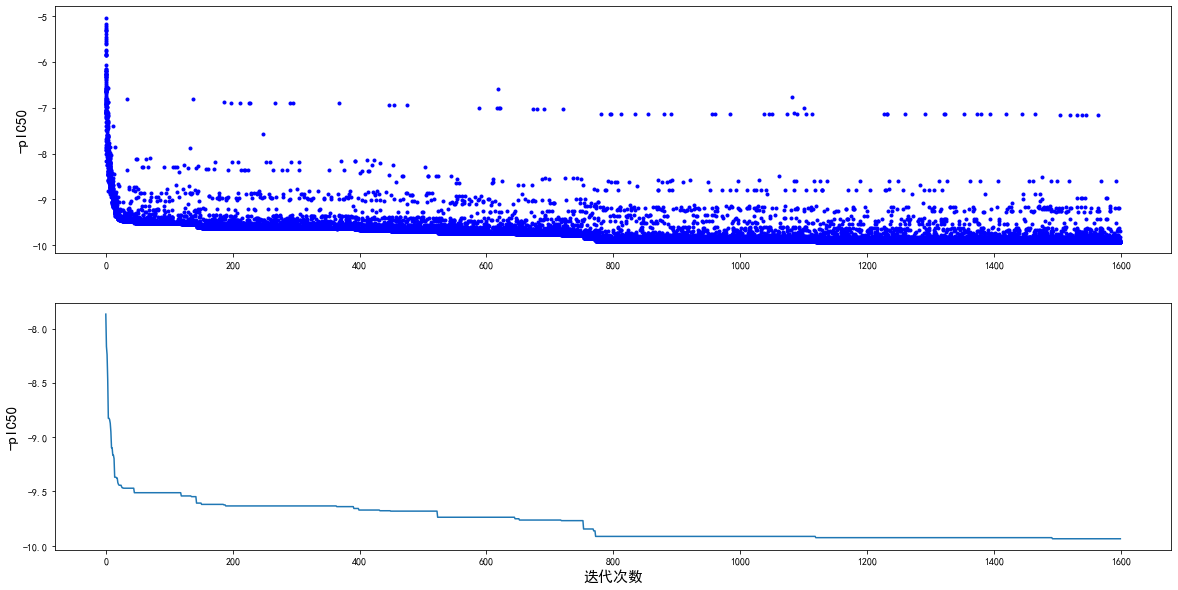

In [353]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Y_history = pd.DataFrame(ga.all_history_Y)
#fig = plt.figure(10,8)
fig, ax = plt.subplots(2, 1,figsize=(20, 10))
#ax.set_title('生物活性参数优化过程图')
ax[0].plot(Y_history.index, Y_history.values, '.', color='blue')
Y_history.min(axis=1).cummin().plot(kind='line')
ax[0].set_ylabel('-pIC50',size=15)
plt.xlabel("迭代次数",size=15)
plt.ylabel('-pIC50',size=15)  # 纵坐标轴标题
plt.savefig(r"./outgraphic/Y_pic50SA.png")
plt.show()

In [294]:
ga.generation_best_X

[array([    8.435 ,    10.9475,    -0.3702,   908.1742,    32.7249,
            2.1423,     0.6024,     4.287 ,    -3.0504,     8.2157,
           12.471 ,     0.0774,     4.0958,     6.5019,    -2.2878,
           14.7618,    -1.5679,     2.7539,    65.446 ,    13.2021,
           21.4561,     0.4149,     0.4258,     7.2301,    51.2538,
            0.0795, 73245.4557,     0.3548,     9.8265,     1.523 ,
           43.1873,    62.4482,  3857.1345,    19.23  ,    40.6016,
           18.0458,     1.2196,     0.5495,     0.3406,     4.0226,
           39.3164,    68.1609,    18.0782,    16.0569,     2.7886,
            6.529 ,    37.0388]),
 array([    8.435 ,    10.9475,    -0.3702,   904.4729,    17.6792,
            2.7018,     0.0503,    13.4268,    -0.1511,     0.1765,
            1.1152,     1.0311,     4.0958,     6.5019,    -2.2878,
           14.7618,    -1.5676,     2.7539,    65.446 ,    13.2021,
           21.4561,     0.4149,     0.4258,     7.2301,    51.2538,
            0.

In [299]:
ga.all_history_Y

[array([-7.0938, -7.1148, -5.2542, -6.2855, -6.9808, -7.0369, -6.5849,
        -6.388 , -6.1412, -6.2023, -6.3038, -5.4867, -6.4398, -6.2585,
        -6.9315, -5.5488, -6.3183, -6.8798, -6.5997, -7.8672, -5.3251,
        -6.839 , -6.2654, -5.8395, -6.2586, -5.219 , -6.6528, -6.9095,
        -6.908 , -7.8462, -6.6363, -6.0561, -5.5757, -6.8611, -6.9096,
        -7.2316, -6.6308, -6.1437, -6.3262, -6.3298, -6.53  , -5.1677,
        -5.7565, -5.0288, -5.6077, -5.2959, -5.8188, -5.7356, -5.4418,
        -6.2665]),
 array([-7.9169, -6.7507, -7.4891, -6.8798, -5.3946, -7.0464, -6.793 ,
        -7.0938, -6.9669, -6.9804, -6.5677, -6.2654, -7.1148, -7.0606,
        -7.1744, -6.8312, -6.6543, -6.7883, -7.2009, -6.5569, -6.1937,
        -6.6308, -7.0472, -7.7206, -6.6946, -7.1246, -8.0084, -5.3023,
        -7.1148, -6.8015, -5.8398, -5.8453, -6.9096, -6.591 , -7.8119,
        -8.1647, -6.2023, -7.1148, -6.6631, -6.4786, -7.6723, -6.2017,
        -6.3624, -6.9028, -7.0957, -7.3872, -6.6308, -7.31

In [196]:
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

best_x: [ 2.60026882e+00  1.39437138e+01 -4.17539144e-01  5.02483654e+02
  1.77853538e+01  2.61538936e+00  1.37446097e-02  5.37525464e+00
 -8.94985960e-01  4.88725094e+00 -3.09575172e+00  7.64260431e-01
  1.12204847e+00  3.53457708e+00 -2.11716162e+00  1.24825382e+00
  4.02948472e+00  2.75846363e+00  1.28734099e+01  1.17336252e+01
  3.93422098e+01  4.00041353e-01  3.87983036e-01  2.19149717e+00
  7.55073374e+01  3.75982521e-02  1.79178044e+03  3.51161756e-01
  2.83138274e+00  1.58950076e-01  5.00563655e+01  2.74255817e+00
  1.05287307e+04  1.79741603e+01  4.46838982e+01  2.10067070e+01
  2.35401637e-01  7.20498907e-01  2.07794929e-02  9.12785218e+00
  6.72569201e+01  1.68032695e+01  3.39531636e+01  1.82429521e+01
  3.61065110e+00  3.18745133e+00  8.44828316e+00] 
 best_y: [-9.9140874]


In [203]:
help(lgb.LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', cate

In [216]:
cls_lgb_last.predict_proba(best_x.reshape(1, -1))[0][1]

0.008251869671398206

In [209]:
last_features

['SssO',
 'minsF',
 'BCUTc-1l',
 'TopoPSA',
 'MDEC-33',
 'minsssN',
 'FMF',
 'maxsF',
 'SaaS',
 'C3SP2',
 'SdssC',
 'minHCsats',
 'MLFER_A',
 'maxssO',
 'minaaS',
 'WTPT-4',
 'ALogP',
 'nS',
 'SHBint10',
 'XLogP',
 'SP-1',
 'ETA_Shape_Y',
 'nsOm',
 'minHBint10',
 'Kier2',
 'ETA_dEpsilon_D',
 'fragC',
 'BCUTc-1h',
 'VPC-6',
 'MDEO-22',
 'SP-2',
 'Kier3',
 'ECCEN',
 'nHBDon_Lipinski',
 'MDEC-23',
 'LipoaffinityIndex',
 'nT11Ring',
 'maxHsOH',
 'VC-4',
 'minHBa',
 'SP-0',
 'ETA_Beta_s',
 'nC',
 'C1SP2',
 'nssO',
 'BCUTp-1l',
 'nHBAcc']

In [210]:
reg_features

['maxHsOH',
 'MDEC-23',
 'LipoaffinityIndex',
 'MLFER_A',
 'C1SP2',
 'BCUTc-1l',
 'C3SP2',
 'minsssN',
 'XLogP',
 'VPC-6',
 'maxsF',
 'nHBAcc',
 'MDEC-33',
 'BCUTp-1l',
 'maxssO',
 'SdssC',
 'SHBint10',
 'nC',
 'TopoPSA',
 'BCUTc-1h']

In [211]:
reg_index = []
for f in reg_features:
    for item in last_features:
        if f == item:
            reg_index.append(last_features.index(item))
reg_index

[37, 34, 35, 12, 43, 2, 9, 5, 19, 28, 7, 46, 4, 45, 13, 10, 18, 42, 3, 27]

In [212]:
cls_features_max = []
cls_features_min = []

for i in range(len(features_max)):
    if i not in reg_index:
        cls_features_max.append(features_max[i])

for i in range(len(features_min)):
    if i not in reg_index:
        cls_features_min.append(features_min[i])

print(f"max：{len(cls_features_max)}")
print(f"min：{len(cls_features_min)}")

max：27
min：27


In [215]:
best_x[5]

-3.095751720507355

In [225]:
def cls_func(x):
    reg_index = [37, 34, 35, 12, 43, 2, 9, 5, 19, 28, 7, 46, 4, 45, 13, 10, 18, 42, 3, 27]
    #注意这里要固定生物活性影响的参数
    #x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27 = x
    input_x = []
    idx= 0 
    for i in range(47):
        if i not in reg_index:
            input_x.append(x[idx])
            idx += 1
        else:
            input_x.append(best_x[i])
    input_x = np.array(input_x)
    out = cls_lgb_last.predict_proba(input_x.reshape(1, -1))[0][0]
    return out

In [269]:
ga_cls = GA(func=cls_func, n_dim=27, size_pop=60, max_iter=800, lb=cls_features_min, ub=cls_features_max)

In [327]:
ga2_cls = GA(func=cls_func, n_dim=27, size_pop=280, max_iter=1800, lb=cls_features_min, ub=cls_features_max)
best2_cls_x, best2_cls_y = ga2_cls.run()
best2_cls_x, best2_cls_y

(array([  21.2307,    4.3279,    0.206 ,   -1.779 ,    0.4166,   -0.6514,
          12.6044,    4.5711,    2.3979,    6.8024,    0.2919,    0.4701,
           2.6076,   21.0501,    0.0276, 3636.6956,    0.0919,    6.0352,
           1.8792,  252.44  ,   46.3522,    1.8084,    0.2598,    2.9918,
          15.9589,   11.6939,    3.0126]),
 array([0.2489]))

In [270]:
best_cls_x, best_cls_y = ga_cls.run()

In [271]:
best_cls_x, best_cls_y

(array([ 2.42536097e+01,  8.83927026e+00,  3.11978543e-01, -2.34266226e+00,
         9.01692422e-01, -1.85943040e+00,  2.73815652e+01, -1.87553511e+01,
         5.85563519e+00,  8.93791816e+00,  3.83009422e-01,  1.41973226e+00,
         3.57565161e+00,  8.63586853e+00,  3.95894063e-03,  2.22955550e+03,
         4.92657890e-02,  5.73440876e+00,  1.57834306e+00,  2.11347212e+02,
         2.87628654e+01,  1.49615447e+00,  4.17666485e-01, -1.47123192e+00,
         1.63184865e+01,  1.10223463e+01,  8.61434428e-01]),
 array([0.40376766]))

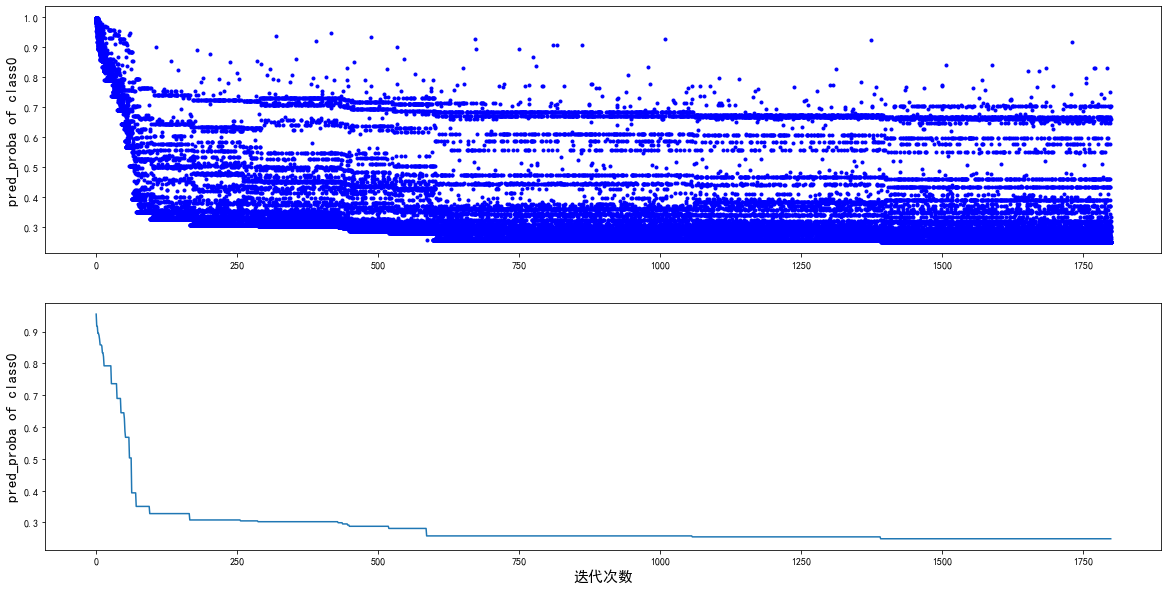

In [354]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Y_history = pd.DataFrame(ga2_cls.all_history_Y)
#fig = plt.figure(10,8)
fig, ax = plt.subplots(2, 1,figsize=(20, 10))
#ax.set_title('')
ax[0].plot(Y_history.index, Y_history.values, '.', color='blue')
Y_history.min(axis=1).cummin().plot(kind='line')
ax[0].set_ylabel('pred_proba of class0',size=15)
plt.xlabel("迭代次数",size=15)
plt.ylabel('pred_proba of class0',size=15)  # 纵坐标轴标题
plt.savefig(r"./outgraphic/Y_ADMETSA.png")
plt.show()

生成最终的特征参数

In [276]:
idx=0
ques4out = []
for i in range(47):
    if i not in reg_index:
        ques4out.append(best_cls_x[idx])
        idx += 1
    else:
        ques4out.append(best_x[i])
ques4out = np.array(ques4out)

In [290]:
np.set_printoptions(precision=4) 

In [332]:
idx=0
new_out = []
for i in range(47):
    if i not in reg_index:
        new_out.append(best2_cls_x[idx])
        idx += 1
    else:
        new_out.append(best_x[i])
new_out = np.array(new_out)

In [291]:
ques4out

array([  24.2536,    8.8393,   -0.4175,  502.4837,   17.7854,    2.6154,
          0.312 ,    5.3753,   -2.3427,    4.8873,   -3.0958,    0.9017,
          1.122 ,    3.5346,   -1.8594,   27.3816,  -18.7554,    5.8556,
         12.8734,   11.7336,    8.9379,    0.383 ,    1.4197,    3.5757,
          8.6359,    0.004 , 2229.5555,    0.3512,    2.8314,    0.0493,
          5.7344,    1.5783,  211.3472,   28.7629,   44.6839,   21.0067,
          1.4962,    0.7205,    0.4177,   -1.4712,   16.3185,   11.0223,
         33.9532,   18.243 ,    0.8614,    3.1875,    8.4483])

In [358]:
pd.DataFrame(last_features, ques4out).to_csv("./aaaa.csv")

In [278]:
last_reg_lgb.predict(ques4out.reshape(1,-1))

array([8.77921762])

In [333]:
last_reg_lgb.predict(new_out.reshape(1,-1))

array([8.3991])

In [281]:
cls_lgb_last.predict(ques4out.reshape(1, -1))

array([1], dtype=int64)